# Running experiments on a cluster

For many research projects in quantum error correction, running experiments on a computer cluster is needed to produce convincing results on large code distances. PanQEC contains an extensive set of tools to help you run experiments on a cluster painlessly. It includes commands to run experiments in parallel on a given number of cores, to generate scripts for Slurm, SGE and PBS cluster management systems, to automatically save experiments in real-time, and to check the progress of your experiments at any point.

In this tutorial, we will cover the whole pipeline of a cluster experiment, from creating the input files to plotting the final results on your laptop.

## Folder structure

In this tutorial, we will adopt the following folder structure for the experiment:

* `my-experiment/`: root folder that will contain all the data of the experiments
    * `my-experiment/inputs/`: contains the input json file(s)
    * `my-experiment/results/`: contain the result json files (once the experiments is running)
    * `my-experiment/logs/`: contain the log files of the experiment, such as the current progress and the CPU/RAM usage.
    
The `my-experiment` folder and the `inputs` subfolder will be automatically generated with the `panqec generate-input` command. The subfolders `results` and `logs` will be created automatically when starting the experiment.

## Creating the input files

PanQEC works by processing input files written in a `json` format. Those specify most details of the experiments you want to run: the code/decoder/error model to use and their parameters, the lattice sizes, the physical error rates, etc. 
Here is an example of input file that describes a 2D toric code simulation under depolarizing noise, decoded using minimum-weight perfect matching:

```json
{
    "comments": "",
    "ranges": {
        "label": "toric-2d-experiment",
        "method": {
            "name": "direct",
            "parameters": {}
        },
        "code": {
            "name": "Toric2DCode",
            "parameters": [
                {
                    "L_x": 5,
                    "L_y": 5,
                },
                {
                    "L_x": 7,
                    "L_y": 7,
                },
                {
                    "L_x": 9,
                    "L_y": 9,
                }
            ]
        },
        "error_model": {
            "name": "PauliErrorModel",
            "parameters": {
                "r_x": 0.33333333333333337,
                "r_y": 0.33333333333333337,
                "r_z": 0.3333333333333333
            }
        },
        "decoder": {
            "name": "MatchingDecoder",
            "parameters": {}
        },
        "error_rate": [
            0.1,
            0.11,
            0.12,
            0.13,
            0.14,
            0.15,
            0.16,
            0.17,
            0.18,
            0.19,
            0.2,
        ]
    }
}
```

Let's analyze the different parts of this input json file:

* `label` is a name you want to give to this experiment
* `method` specifies the simulation method. For the moment, there are two different methods: `direct` and `splitting`. The direct method consists in sampling independent errors at each Monte-Carlo round, while the splitting method samples errors using a Monte-Carlo Markov Chain algorithm introduced in [this paper](https://arxiv.org/abs/1308.6270) by Bravyi and Vargo. The splitting method has not been as thoroughly tested as the direct one in PanQEC at the moment, and we would advise against using it.
* `code`: name and parameters of the code. The list of all codes can be found using the command line `panqec ls codes`. `L_x`, `L_y` (and `L_z` for 3D codes) define the lattice dimensions.
* `error_model`: name and parameters of the error model. At the moment, there is only one error model called `PauliErrorModel`, which samples i.i.d Pauli errors at each run, without any measurement error. It is specified by three parameters, (`r_x`, `r_y`, `r_z`), which define the rate of Pauli $X$, $Y$ and $Z$ errors respectively. They should therefore all lie between $0$ and $1$ and satisfy the constraint $r_x+r_y+r_z=1$.
* `decoder`: name and parameters of the decoder. The list of all decoders can be found using the command line `panqec ls decoders`.
* `error_rate`: list of physical error rates included in the simulation.

The above input file can be generated it using the `panqec generate-input` command as follows.

```bash
panqec generate-input -d "my-experiment" \
    --code_class Toric2DCode --sizes "5x5,7x7,9x9" \
    --decoder_class MatchingDecoder \
    --bias "Z" --eta "0.5" \
    --prob "0.1:0.2:0.01"
```

The above command will create a directory called `my-experiment` in the current working directory with the file structure previously described. Specifically, the input file will be written to `my-experiment/inputs/experiment.json`, which you may inspect.

The only non-obvious parameters might be `bias` and `eta`. The parameter `bias` can be either `X`, `Y` or `Z`, and `eta` can be any value between `0.5` and `inf`, where `eta=0.5` corresponds to depolarizing noise and `eta=inf` to pure {X,Y,Z} noise (depending on the value of `bias`). See `panqec generate-input --help` for more information.

To test that the input file is correct and that all the libraries are correctly installed, we recommand you to do a mock run with the following command:

```bash
panqec run -i my-experiment/inputs/experiment.json -o mock.json.gz -t 10
```

This will run your experiment with 10 trials and store the result in a compressed json file `mock.json.gz`

## Generating cluster script

PanQEC has a command to automatically generate a cluster script, namely `panqec generate-cluster-script`. Its first input is a *header file*. It should contain the template for the first few lines a cluster script, which must be tailored for your specific cluster. Here is an example of a header file for Slurm: (Note that your cluster may require slightly a slightly different format)

```bash
#!/bin/bash
#SBATCH -N 1
#SBATCH -t ${TIME}
#SBATCH --cpus-per-task=${N_CORES}
#SBATCH --exclusive
#SBATCH --job-name=${NAME}
#SBATCH --array=1-${N_NODES}
#SBATCH --mem=${MEMORY}
#SBATCH -p ${QUEUE}
#SBATCH --output=${DATA_DIR}/%j.out

module purge
module load gcc/devtoolset/9
module load anaconda/anaconda3.7
source ~/.bashrc
```

All the variables enclosed by `${}` will be replaced by an actual value in generated cluster scripts. 
Once you have this header ready, let's say in a file `slurm_header.sbatch`, you can run the following command:

```bash
panqec generate-cluster-script \
       slurm_header.sbatch \
       --output-file my-experiment/run.sbatch \
       --data-dir my-experiment \
       --cluster slurm \
       --trials 10000 \
       --n-nodes 8 \
       --n-cores 5 \
       --wall-time "00:10:00" \
       --memory "1G" \
       --partition debug \
       --delete-existing
```

You should now have the following content in the generated cluster script `my-experiment/run.sbatch`:

```bash
#!/bin/bash
#SBATCH -N 1
#SBATCH -t 00:10:00
#SBATCH --cpus-per-task=5
#SBATCH --exclusive
#SBATCH --job-name=my-experiment
#SBATCH --array=1-8
#SBATCH --mem=1G
#SBATCH -p debug
#SBATCH --output=my-experiment/%j.out

module purge
module load gcc/devtoolset/9
module load anaconda/anaconda3.7
source ~/.bashrc

panqec monitor-usage my-experiment/logs/usage_$SLURM_JOB_ID_$SLURM_ARRAY_TASK_ID.txt &

panqec run-parallel -d my-experiment -n 8 -j $SLURM_ARRAY_TASK_ID -c 5 -t 10000 --delete-existing

date
```

As you can see, it first contains a command to monitor the resource usage (CPU and RAM), which will be stored in the logs directory. The second command, `run-parallel`, parallelizes the 10000 Monte Carlo trials over all the nodes and cores, and runs the simulation on the current node of the job array.

## Running the script and checking progress

Simply run the script generated above with your cluster system command to submit jobs. For instance, in Slurm, enter:

```bash
sbatch my-experiment/run.sbatch
```

You can check the progress of the experiment with the command

```bash
panqec check-progress my-experiment/logs
```

The above will display a progress bar shown how much has been completed.
You can add the option `-a` to inspect the progress on all the cores individually

You can also graphically check the usage of available resources using
```
panqec check-usage my-experiment/
```
which will plot the RAM and CPU usage over time in the command line.

## Aggregating and analyzing results

Once the experiment is running, all the results will be regularly saved in the files `my-experiment/results/results_[i].json.gz` where `[i]` is the index of the core. At any moment during the experiment, you can merge the results into a single file and send it to your laptop for analysis. Here is the command you need to run:

```bash
panqec merge-results my-experiment/results/results_* -o my-experiments/merged-results.json.gz
```

You can then send the file `my-experiment/merged-results.json.gz` to your laptop using `scp`, `rsync` or an equivalent method. For example, if `my-experiment` is in your cluster's home directory then you can sync it to a local directory called `my-experiment/` on your laptop by running the following command on your laptop:
```
rsync -avzhe ssh user@example.com:~/my-experiments/merged-results.json.gz my-experiment/
```
Of course, you should replace `user` and `example.com` with your appropriate username and cluster URL.

The following piece of code, which you can run locally on a Jupyter Notebook, will allow you to quickly visualize the obtained data for all errors, X errors and Z errors.

Finding files
Found 1 files
Reading files
Aggregating data
Calculating total error rates
Calculating word error rates
Calculating single qubit error rates
Finding files
Found 1 files
Reading files
Aggregating data
Calculating total error rates
Calculating word error rates
Calculating single qubit error rates
Calculating single-qubit sector thresholds thresholds
Plotting Toric2DCode, PauliErrorModel(r_x=0.333333, r_y=0.333333, r_z=0.333333, deformation_name=None, deformation_kwargs={}), MatchingDecoder(error_type=None, weights=None), total


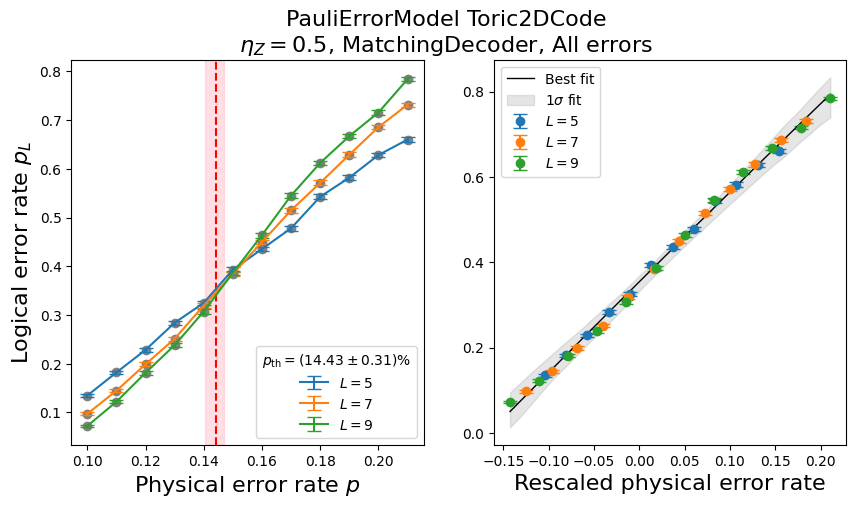

Plotting Toric2DCode, PauliErrorModel(r_x=0.333333, r_y=0.333333, r_z=0.333333, deformation_name=None, deformation_kwargs={}), MatchingDecoder(error_type=None, weights=None), X


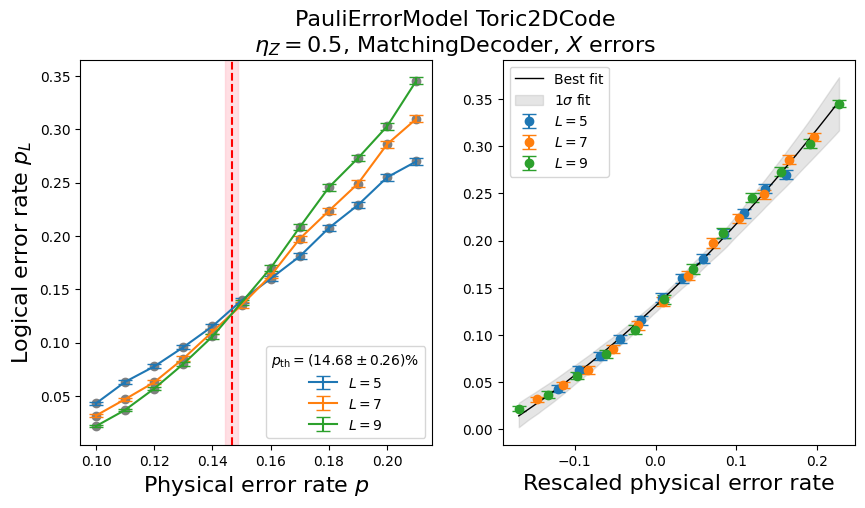

Plotting Toric2DCode, PauliErrorModel(r_x=0.333333, r_y=0.333333, r_z=0.333333, deformation_name=None, deformation_kwargs={}), MatchingDecoder(error_type=None, weights=None), Z


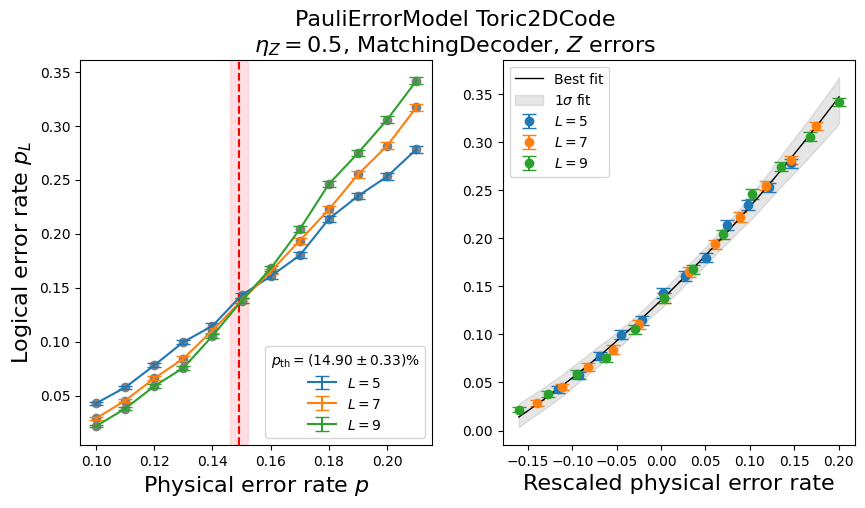

In [1]:
from panqec.analysis import Analysis
analysis = Analysis("my-experiment/merged-results.json.gz")
analysis.analyze()
analysis.make_collapse_plots()

If you wish to inspect the data yourself, just use the `get_results()` method.
For example,

In [2]:
df = analysis.get_results()
df[['code', 'd', 'error_model', 'bias', 'decoder', 'error_rate', 'n_fail', 'n_trials']]

,code,d,error_model,bias,decoder,error_rate,n_fail,n_trials
0,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.10,1347,10000
1,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.11,1821,10000
2,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.12,2284,10000
3,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.13,2841,10000
4,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.14,3249,10000
5,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.15,3931,10000
6,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.16,4355,10000
7,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.17,4781,10000
8,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.18,5428,10000
9,Toric2DCode,5,PauliErrorModel,0.5,MatchingDecoder,0.19,5820,10000


In the above table, `error_rate` is the physical error rate,
`n_fail` is the number of decoding failures and `n_trials` is the number of trials simulated.

You can also inspect the numerical values of the threshold estimates.

In [3]:
analysis.thresholds[['code', 'error_model', 'bias', 'sector', 'p_th_fss', 'p_th_fss_left', 'p_th_fss_right']]

,code,error_model,bias,sector,p_th_fss,p_th_fss_left,p_th_fss_right
0,Toric2DCode,PauliErrorModel,0.5,total,0.144347,0.140330,0.147065
1,Toric2DCode,PauliErrorModel,0.5,Z,0.149021,0.146049,0.152246
2,Toric2DCode,PauliErrorModel,0.5,X,0.146849,0.144273,0.148747


In the above table, `sector` is the type of errors considered,
`p_th_fss` is the threshold estimate by finite-size scaling and
`p_th_fss_left` and `p_th_fss_right` are left and right $1\sigma$ CI bounds on the estimate.